# Plot link lengths


### Imports

In [2]:
%pylab inline
import seaborn as sbn
import networkx as nx
import pickle
import scipy as sp
import scipy.stats
from scipy.optimize import curve_fit
import glob
import os
import Bio
import MDAnalysis as mda
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Theory function definitions


In [33]:
def nth_harmonic(n):
    '''
    Compute the nth harmonic number, i.e. the sum of the reciprocals of the first n natural numbers.
    
    Parameters
    ----------
    n: int
        The number of natural numbers for the harmonic.
    
    Return
    ------
    harmonic: float
        The nth harmonic number.
    '''
    # Ensure n is an integer
    N = int(n)
    # Initialise the harmonic number as 1
    harmonic = 1.00
    for i in range(2, N + 1):
        harmonic += 1/i
    return harmonic


def f_high(link_length, chain_length, half_N_harmonic):
    '''
    Calculate f for k >> 1. 
    
    Parameters
    ----------
    link_length: int
        The separation s betweeen each link. Bounds: 2 <= s < N/2
    chain_length: int
        The chain length, i.e. number N of C-alphas in a chain. 
        Also the maxium possible links at the start. 
    half_N_harmonic: float
        The "N/2"-th harmonic number. 
    
    Return
    ------
    f_high: float
        The sequence distribution evaluated at a given link_length, 
        with k >> 1.
    '''
    H_s = nth_harmonic(link_length)
    f_high = (2/N) * (((half_N_harmonic - H_s + 1) / (half_N_harmonic - 1)) * link_length - (half_N_harmonic / (half_N_harmonic - 1)))
    return f_high


def f_low(link_length, chain_length):
    '''
    Calculate f for k << N/2. 
    
    Parameters
    ----------
    link_length: int
        The separation s betweeen each link. Bounds: 2 <= s < N/2
    chain_length: int
        The chain length, i.e. number N of C-alphas in a chain. 
        Also the maxium possible links at the start. 

    Return
    ------
    f_low: float
        The sequence distribution evaluated at a given link_length, 
        with k << N/2.
    '''
    f_low = - (2/chain_length**2) * link_length**2 + ((2/chain_length) + (6/chain_length))*link_length - ((2/chain_length) + (4/chain_length**2))
    return f_low

def P_link_lengths(link_length, chain_length, half_N_harmonic, a, A):
    '''
    Evaluate the probability distribution of the realised residue distances
    of all added links, as given by the final approximation in Eq.(12) with
    all C_k = A.
    
    Parameters
    ----------
    link_length: int
        The separation s betweeen each link. Bounds: 2 <= s < N/2
    chain_length: int
        The chain length, i.e. number N of C-alphas in a chain. 
        Also the maxium possible links at the start. 
    half_N_harmonic: float
        The "N/2"-th harmonic number. 
    a: int
        The number of steps used from Eq.(7).
    A: int 
        The factor from the geometric series in Eq.(12), i.e. C_k = A.
    
    Return
    ------
    P: float
        Probability distribution of the realised residue distances 
        of all added links.
    '''
    f_l = f_low(link_length, chain_length)
    f_h = f_high(link_length, chain_length, half_N_harmonic)
    P = (((1-f_l)/(1-f_h))**a) * (A/f_h)
    return P

def P_in_link_lengths(link_length, chain_length, half_N_harmonic, a, k):
    '''
    Evaluate the probability distribution of the realised residue distances
    of all added links, as given by Eq.(12), with N/(N-3) approx. 1 and 
    C_k not all set to C.
    
    Parameters
    ----------
    link_length: int
        The separation s betweeen each link. Bounds: 2 <= s < N/2
    chain_length: int
        The chain length, i.e. number N of C-alphas in a chain. 
        Also the maxium possible links at the start. 
    half_N_harmonic: float
        The "N/2"-th harmonic number. 
    a: int
        The number of steps used from Eq.(7).
    k: int 
        The power k used in Eq.(11), i.e. the step number.
    
    Return
    ------
    P_in: float
        Probability distribution of the realised residue distances 
        of all added links.
    '''
    
    sum_range_C_k = range(2, N//2)
    
    for s in sum_range_C_k:
        f_low = f_low(s, chain_length)
        f_high = f_high(s, chain_length, half_N_harmonic)
        C_k = sum(F_k(f_low, f_high, chain_length, a, k))
    
    f_low = f_low(link_length, chain_length)
    f_high = f_high(link_length, chain_length, half_N_harmonic)
    P_in = (F_k(f_low, f_high, chain_length, a, k))/C_k + 100
    return P_in

def F_k(f_low, f_high, chain_length, a, k):
    '''
    Calculate the F_k distribution as given in Eq.(11). 
    That is, create the pool from which we draw links at step k. 
    
    Parameters
    ----------
    f_low: float
        The sequence distribution evaluated at a given link_length, 
        with k << N/2.
    f_high: float
        The sequence distribution evaluated at a given link_length, 
        with k >> 1.
    chain_length: int
        The chain length, i.e. number N of C-alphas in a chain. 
        Also the maxium possible links at the start. 
    a: int
        The number of steps used from Eq.(7).
    k: int
        The power k used in Eq.(11), i.e. the step number.

    Return
    ------
    F_k: float
        The function given in Eq.(11).
    '''
    F_k = chain_length * (((1 - f_low)/(1 - f_high))**a) * (1 - f_high)**k
    return F_k

def powerlaw(link_length_array, chain_length):
    '''
    Compute the power law relationship: N * (1/x^1.2)
    
    Parameters
    ----------
    link_length_array: array
        The separations s betweeen each link. Bounds: 2 <= s < N/2
    chain_length: int
        The chain length, i.e. number N of C-alphas in a chain. 
        Also the maxium possible links at the start.         
    
    Return
    ------
    pwr: float
        Power law relationship N * (1/x^1.2)
    '''
    pwr = N * (1/pow(link_length_array, 1.2))
    return pwr

## Functions for plotting

In [34]:
def get_simulation_data(length):
    '''
    Get simulation data for a given length.
    
    Parameters
    ----------
    length: str
        Link length: 100, 200 or 300.
    
    Return
    ------
    sim_data_tuple: tuple
        A tuple containing the simulation data histogram and the
        data edges from the histogram.
    '''
    simulation_data_files = glob.glob(f'../data/simulation_data/Nora50_matrix_{length}_*')
    link_length_list = []
    histogram = None
    # Loop over simulation files
    for file in simulation_data_files:
        matrix = np.loadtxt(file)
        '-----------------------'
        matrix[matrix > 1] = 0 # ???
        '-----------------------'
        protein_graph = nx.from_numpy_matrix(matrix)
        links = list(protein_graph.edges())
        for link in links:
            link_length_list.append(abs(link[0] - link[1]))
        histogram, edges = np.histogram(link_length_list, bins = range(3, 1000), density = True)
    # Normalise over the number of simulations
    histogram = histogram / len(simulation_data_files)
    sim_data_tuple = (histogram, edges)
    return sim_data_tuple

    
    
def normalise_data(data_array, bin_width):
    '''
    Take a data array and width of bins and normalise the data array.
    
    Parameters
    ----------
    data_array: np.ndarray
        Array of data to be normalised
    bin_width: int
        Width of a bin from the histogram.
   
    Return
    ------
    normalised_array: np.ndarray
        Normalised data array.
    '''
    data_sum = 0
    for i in range(len(data_array)):
        data_sum += data_array[i] * bin_width
    normalised_array = data_array / data_sum
    return normalised_array



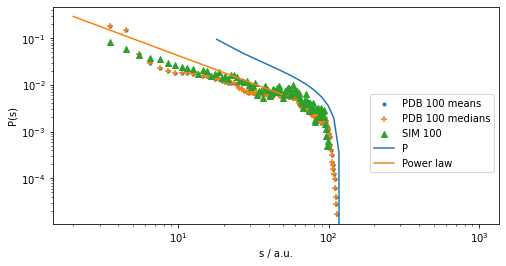

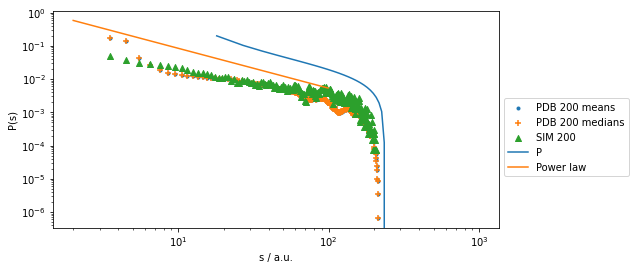

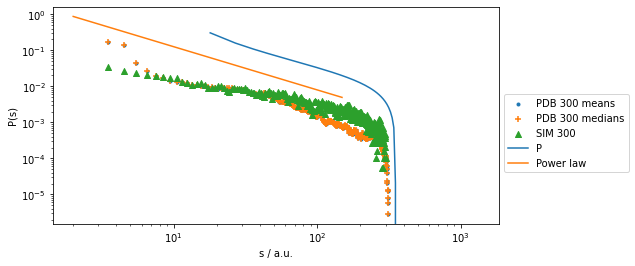

In [70]:
link_length_ranges = ['100', '200', '300']

for link_length in link_length_ranges:
    
    # Load PDB data
    pdb_ids = np.load(f'data_for_plotting/ids_{link_length}.npy')
    pdb_mean_data = np.load(f'data_for_plotting/means_{link_length}.npy')
    pdb_median_data = np.load(f'data_for_plotting/medians_{link_length}.npy')
    
    # Load simulation data
    if link_length == '200':
        sim_data, sim_edges = get_simulation_data('209')
    elif link_length == '300':
        sim_data, sim_edges = get_simulation_data('302')
    else: 
        sim_data, sim_edges = get_simulation_data(link_length)
    #sim_data, sim_edges = get_sim_data_for_given_length(link_length)
    # Get PDB bin widths and centres
    pdb_edges = range(3, 1000)
    pdb_bin_centres = pdb_edges[:-1] + np.diff(pdb_edges)/2
    pdb_bin_width = pdb_edges[1] - pdb_edges[0]
    
    # Get simulation bin widths and centres
    sim_bin_centres = sim_edges[:-1] + np.diff(sim_edges)/2
    sim_bin_width = sim_edges[1] - sim_edges[0]
    
    # Normalise PDB data
    pdb_mean_data = normalise_data(pdb_mean_data, pdb_bin_width)
    pdb_median_data = normalise_data(pdb_median_data, pdb_bin_width)
    
    # Normalise simulation data
    sim_data = normalise_data(sim_data, sim_bin_width)
    
    # Plotting
    fig = plt.figure(figsize = (8,4))
    ax = fig.add_subplot()
    
    # Plot PDB data
    ax.scatter(pdb_bin_centres, pdb_mean_data, marker = '.', label = f'PDB {link_length} means')
    ax.scatter(pdb_bin_centres, pdb_median_data, marker = '+', label = f'PDB {link_length} medians')

    # Plot simulation data 
    ax.scatter(sim_bin_centres, sim_data, marker = '^', label = f'SIM {link_length}')
    
    # Plot theory 
    N=int(link_length)
    H_N_2=nth_harmonic(N//2)
    A=0.19
    a=0.9
    sumrange=range(2,N//2)
    plotrange=range(20,N//2)
    ax.plot(np.array(sumrange)*9,[P_link_lengths(s,N,H_N_2,a,A)/90  for s in sumrange],label='P')
    ax.plot(np.array(sumrange), powerlaw(np.array(sumrange), N)/150, label = 'Power law')
    
    
    ax.set_yscale('log')
    ax.set_xscale('log')
 #   ax.set_xlim([5,150])
 #   ax.set_ylim([0.0001, 1000])
    ax.legend(bbox_to_anchor=(1,0.62))
    ax.set_ylabel('P(s)')
    ax.set_xlabel('s / a.u.')
    plt.show()